### Import Necessary Packages

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns

from textblob import TextBlob, Blobber # POS tagging
from textblob import Blobber

## Attempt #1: A Naive Method for Subject Searching

**Michelle Ragsac, Clarence Mah**

With this naive approach to disease mention identification within biomedical literature, we will be using a part of speech (POS) tagger package in Python, `TextBlob`, to extract all of the noun phrases within our medical text (using `TextBlob.noun_phrases`). Our medical text is a PubMed article Title and Abstract concatenated together with a `" "` character derived from the [NCBI Disease Corpus](https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/). 

Next, we will compare this set of words to the [5,000 most commonly used words in the English language](https://www.wordfrequency.info/intro.asp) from Mark Davies, [a Professor of Linguistics at Brigham Young University](https://corpus.byu.edu/faq.asp#x1), in an attempt to remove non-medically associated words. 

This final word set will be considered our set of "disease" mentions within our biomedical text, as we have no way to easily distinguish between which words constitute a disease, and which words do not correctly classify as disease mentions. For comparisons, the ground truths or true positives will be the set of disease words that were manually annotated by the NCBI Disease Corpus team.

### Importing the NCBI Disease Corpus

To start off our analysis, we'll import all of the datasets from the NCBI Disease Corpus. They are stored into `NCBIdevelopset_corpus.txt`, `NCBItestset_corpus.txt`, and `NCBItrainset_corpus.txt` files. For this naive approach, we will not perform any training, so we will combine all of the sets together when we compile our final analysis of this approach. 

But within this notebook, we will first demonstrate our methods on a single entry before evauating everything together.

#### Generate a method to parse through the text files and convert the contents into a `pandas` Data Frame 

In [2]:
def convert_corpus_dict(FILENAME):
    """HELPER METHOD: given the FILENAME for the NCBI corpus file, convert to pandas dataframe"""
    df = {}
    new_entry = True # tracks if we're evaluating a new pubmed article
    for LINE in open(FILENAME,'r'):
        if LINE == '\n': # articles are separated by newline characters
            new_entry = True
        else:
            if new_entry == True:
                # if LINE contains text & new_entry is True, we have a new article to input w/ title
                new_entry = False 
                PubMed_ID = int(LINE.strip().split("|")[0])
                df[PubMed_ID] = {} # define the new pubmed entry, then extract title 
                df[PubMed_ID]["Title"] = LINE.strip().split("|")[2]
            elif new_entry == False:
                # if LINE contains text & new_entry is False, we have more information to input
                if "|a|" in LINE: # abstract information 
                    df[PubMed_ID]["Abstract"] = LINE.strip().split("|")[2][0:-1]
                elif "\t" in LINE: # identified mentions of diseases, etc.
                    if "Mentions" not in df[PubMed_ID].keys(): 
                        # there might be multiple lines... add first occurence properly
                        df[PubMed_ID]["Mentions"] = []
                    df[PubMed_ID]["Mentions"].append(LINE.strip().split("\t")[1:])
    
    # we've gone through the whole file, so output as proper pandas dataframe
    return(pd.DataFrame(df).T[["Title","Abstract","Mentions"]])

#### Import all of the files

In [3]:
devel_set = 'NCBIdevelopset_corpus.txt'
df_devel = convert_corpus_dict(devel_set)

train_set = 'NCBItrainset_corpus.txt'
df_train = convert_corpus_dict(train_set)

testa_set = 'NCBItestset_corpus.txt'
df_testa = convert_corpus_dict(testa_set)

### Importing the 5,000 Most Common English Words

We'll be importing the 5,000 most common English words from [http://www.wordfrequency.info](http://www.wordfrequency.info); they have larger most frequent English word sets, but those require us to pay for the data. 

We'll stick with what's free... :-)

They also give us information on the part of speech, frequency, and dispersion, but the main thing we want are the words themselves!

In [4]:
# import the text file of 5000 most common English words from http://www.wordfrequency.info
# (https://www.wordfrequency.info/intro.asp)
df_common_english = pd.read_csv('common_english_words.txt',delimiter='\t').set_index('Rank')
print(df_common_english.head())

# gather the most common words and turn it into a set for easy set comparison later
common_words = set(df_common_english[df_common_english.columns[0]])

        Word Part of speech  Frequency  Dispersion
Rank                                              
1        the              a   22038615        0.98
2         be              v   12545825        0.97
3        and              c   10741073        0.99
4         of              i   10343885        0.97
5          a              a   10144200        0.98


### Demonstration of Analysis on Entry#`8808605` (First Entry in Development Corpus Subset)

In [5]:
DEMONSTRATION_ENTRY = df_devel.iloc[0]

We will start this analysis by demonstrating our procedure on a single entry within the NCBI Disease Corpus (the first entry from within the `NCBIdevelopset_corpus.txt`). The `TEXT` contents of this entry can be found below:

In [6]:
DEMONSTRATION_TEXT = DEMONSTRATION_ENTRY["Title"] + " " + DEMONSTRATION_ENTRY["Abstract"]
DEMONSTRATION_TEXT

'Somatic-cell selection is a major determinant of the blood-cell phenotype in heterozygotes for glucose-6-phosphate dehydrogenase mutations causing severe enzyme deficiency. X-chromosome inactivation in mammals is regarded as an essentially random process, but the resulting somatic-cell mosaicism creates the opportunity for cell selection. In most people with red-blood-cell glucose-6-phosphate dehydrogenase (G6PD) deficiency, the enzyme-deficient phenotype is only moderately expressed in nucleated cells. However, in a small subset of hemizygous males who suffer from chronic nonspherocytic hemolytic anemia, the underlying mutations (designated class I) cause more-severe G6PD deficiency, and this might provide an opportunity for selection in heterozygous females during development. In order to test this possibility we have analyzed four heterozygotes for class I G6PD mutations  two with G6PD Portici (1178G-- > A) and two with G6PD Bari (1187C-- > T). We found that in fractionated blood c

#### Extracting Noun Phrases from `DEMONSTRATION_TEXT`

In [7]:
import nltk # natural language toolkit

# generate a textblob object of our text (lowercase everything for normalization purposes)
tb = TextBlob(DEMONSTRATION_TEXT.lower()) 

nltk.download('punkt')
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/mragsac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/mragsac/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mragsac/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/mragsac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
print('\n'.join(tb.noun_phrases))

somatic-cell selection
major determinant
blood-cell phenotype
glucose-6-phosphate dehydrogenase mutations
severe enzyme deficiency
x-chromosome inactivation
random process
somatic-cell mosaicism creates
cell selection
red-blood-cell glucose-6-phosphate dehydrogenase
enzyme-deficient phenotype
small subset
hemizygous males
chronic nonspherocytic hemolytic anemia
class i
more-severe g6pd deficiency
heterozygous females
class i g6pd mutations
g6pd portici
g6pd bari
> t
blood cell types
lymphoid cell lineages
significant excess
g6pd-normal cells
significant concordance
different blood-cell lineages
selective mechanism
pluripotent blood stem cells
severe g6pd deficiency affects
blood cells
phenotypic characteristic


#### Remove Commonly Used English Terms from Biomedical Text

In [9]:
# gather words from our corpus that are commonly used in the English language
common_words_in_corpus = set(common_words) & set(tb.noun_phrases)

# we are assuming that we are left with medically-associated words
medical_words = [i for i in set(tb.noun_phrases) if (i not in common_words_in_corpus)]
medical_words

['somatic-cell selection',
 'cell selection',
 'more-severe g6pd deficiency',
 'hemizygous males',
 'blood-cell phenotype',
 'g6pd bari',
 'glucose-6-phosphate dehydrogenase mutations',
 'major determinant',
 'somatic-cell mosaicism creates',
 'severe enzyme deficiency',
 'blood cell types',
 'red-blood-cell glucose-6-phosphate dehydrogenase',
 'class i g6pd mutations',
 'g6pd portici',
 'significant concordance',
 'chronic nonspherocytic hemolytic anemia',
 'blood cells',
 'small subset',
 'g6pd-normal cells',
 'enzyme-deficient phenotype',
 'class i',
 'significant excess',
 'pluripotent blood stem cells',
 'x-chromosome inactivation',
 'different blood-cell lineages',
 'phenotypic characteristic',
 'selective mechanism',
 'heterozygous females',
 'severe g6pd deficiency affects',
 'lymphoid cell lineages',
 '> t',
 'random process']

#### Extracting the True Disease Mentions from the NCBI Disease Corpus for Comparison Against Naive Method

In [10]:
# print all of the disease mentions made within the text
disease_annotations = []
for ELEMENT in df_devel.iloc[0]["Mentions"]:
    print(ELEMENT)
    disease_annotations.append(ELEMENT[2].lower())

['154', '171', 'enzyme deficiency', 'DiseaseClass', ' D008661']
['376', '427', 'glucose-6-phosphate dehydrogenase (G6PD) deficiency', 'SpecificDisease', 'D005955']
['572', '611', 'chronic nonspherocytic hemolytic anemia', 'SpecificDisease', 'D000746']
['677', '692', 'G6PD deficiency', 'SpecificDisease', 'D005955']
['1368', '1383', 'G6PD deficiency', 'SpecificDisease', 'D005955']


In [11]:
tp = set(medical_words) & set(disease_annotations)
tp

{'chronic nonspherocytic hemolytic anemia'}

In [12]:
fp = [word for word in set(medical_words) if word not in tp]
fp

['somatic-cell selection',
 'cell selection',
 'more-severe g6pd deficiency',
 'hemizygous males',
 'glucose-6-phosphate dehydrogenase mutations',
 'blood-cell phenotype',
 'g6pd bari',
 'major determinant',
 'somatic-cell mosaicism creates',
 'severe enzyme deficiency',
 'blood cell types',
 'red-blood-cell glucose-6-phosphate dehydrogenase',
 'class i g6pd mutations',
 'g6pd portici',
 'significant concordance',
 'blood cells',
 'small subset',
 'g6pd-normal cells',
 'enzyme-deficient phenotype',
 'class i',
 'significant excess',
 'pluripotent blood stem cells',
 'x-chromosome inactivation',
 'different blood-cell lineages',
 'phenotypic characteristic',
 'selective mechanism',
 'heterozygous females',
 'severe g6pd deficiency affects',
 'lymphoid cell lineages',
 '> t',
 'random process']

In [13]:
fn = [word for word in set(disease_annotations) if word not in set(medical_words)]
fn

['g6pd deficiency',
 'enzyme deficiency',
 'glucose-6-phosphate dehydrogenase (g6pd) deficiency']

### Running the Naive Method on All Data

In [14]:
df = pd.concat([df_devel,df_train,df_testa])

experimental = []
true = []
tp = []
fp = []
fn = []
for LINE in df.iterrows():
    # gather biomedical text to evaluate
    tb = TextBlob(LINE[1]["Title"] + " " + LINE[1]["Abstract"])
    
    # determine common english words within text and remove them to generate medical words list
    common_words_in_corpus = set(common_words) & set(tb.noun_phrases)
    medical_words = [i for i in set(tb.noun_phrases) if (i not in common_words_in_corpus)]
    medical_words = list(set([e.lower() for e in medical_words]))
    experimental.append(medical_words)
        
    # gather the true terms from the manual annotations
    true_terms = list(set([e[2] for e in LINE[1]["Mentions"] 
                           if e[3] == "SpecificDisease"]))
    true_terms = [e.lower() for e in true_terms]
    true.append(true_terms)
    
    # calculate tp, fp, fn
    tp.append(len(set(medical_words) & set(true_terms)))
    fp.append(len([e for e in set(medical_words) 
                   if e not in (set(medical_words) & set(true_terms))]))
    fn.append(len([e for e in set(true_terms) if e not in medical_words]))
    
# append medical words identified with model, true medical words from manual annotations, 
# tp, fp, fn values to dataframe for each pubmed article entry
df["Experimental"] = experimental
df["True"] = true
df["TP"] = tp
df["FP"] = fp
df["FN"] = fn

df.head() # preview dataframe

,Title,Abstract,Mentions,Experimental,True,TP,FP,FN
8808605,Somatic-cell selection is a major determinant ...,X-chromosome inactivation in mammals is regard...,"[[154, 171, enzyme deficiency, DiseaseClass, ...","[cell selection, x-chromosome, hemizygous male...","[chronic nonspherocytic hemolytic anemia, gluc...",1,28,2
9050866,"The ataxia-telangiectasia gene product, a cons...",The product of the ataxia-telangiectasia gene ...,"[[4, 25, ataxia-telangiectasia, Modifier, D001...","[exposure, genome damage, cell cycle regulatio...",[],0,23,0
9012409,Molecular basis for Duarte and Los Angeles var...,Human orythrocytes that are homozygous for the...,"[[20, 63, Duarte and Los Angeles variant galac...","[missense mutation, enzyme thermal stability, ...","[duarte enzyme variant of galactosemia, la var...",0,42,2
8755645,An intronic mutation in a lariat branchpoint s...,The first step in the splicing of an intron fr...,"[[78, 102, inherited human disorder, DiseaseCl...","[missense mutation, lecithin cholesterol acylt...","[fed, fish-eye disease]",2,27,0
8751855,Genetic heterogeneity in hereditary breast can...,The common hereditary forms of breast cancer h...,"[[25, 49, hereditary breast cancer, SpecificDi...","[mutation analyses, genetic, common hereditary...","[hereditary breast cancers, hereditary breast ...",2,18,1


### Evaluating Results of Naive Method on Biomedical Literature for Disease Entity Extraction

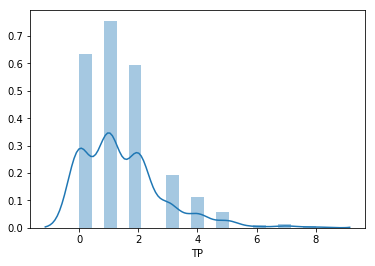

In [15]:
sns.distplot(df["TP"])

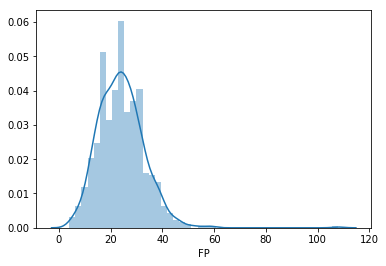

In [16]:
sns.distplot(df["FP"])

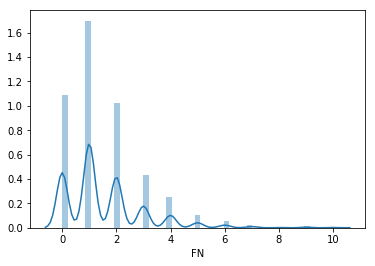

In [17]:
sns.distplot(df["FN"])

In [18]:
micro_recall = (np.sum(df["TP"]) + 1) / (float(np.sum(df["TP"]) + np.sum(df["FN"])) + 1)
micro_precis = (np.sum(df["TP"]) + 1) / (float(np.sum(df["TP"]) + np.sum(df["FP"])) + 1)
micro_f1scor = (2*micro_recall*micro_precis) / float(micro_recall + micro_precis)

print("MICRO RECALL")
print(micro_recall)
print("MICRO PRECISION")
print(micro_precis)
print("MICRO AVERAGED F1")
print(micro_f1scor)

MICRO RECALL
0.48547368421052634
MICRO PRECISION
0.05681762184004337
MICRO AVERAGED F1
0.10172931004058584


In [19]:
def calc_recall(row):
    return((row["TP"]+1) / (float(row["TP"] + row["FN"]) + 1))
def calc_precis(row):
    return((row["TP"]+1) / (float(row["TP"] + row["FP"]) + 1))
def calc_f1(row):
    R = calc_recall(row)
    P = calc_precis(row)
    return(((2*R*P) + 1)/(R + P + 1))

print("MACRO AVERAGED F1")
np.mean(df.apply(lambda row: calc_f1(row), axis=1))

MACRO AVERAGED F1


0.6566344442507479

### Format and Export Final Output

In [20]:
lines = []
for ROW in df.iterrows():
    entry = ROW[0]
    for RESULT in ROW[1]['Experimental']:
        lines.append('{0}\t{1}'.format(entry,RESULT))

f = open("20181205_MR_naive-approach-results.txt", "w")
f.write('\n'.join(lines))
f.close()